## German Credit Optimization
Real Option Optimization

In [550]:
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.optimize import linprog

In [551]:
df = pd.read_csv('~/Documents/My Samples/germancredit_out.csv')
n = len(df)

In [552]:
period = np.array(['Period 1','Period 2'])
region = np.array(['A', 'B', 'C'])
outcome = np.array(['Good','Bad'])
prob = [[0.75, 0.25],[0.82, 0.18],[0.70,0.30]]
pd.DataFrame(prob,index=region,columns=outcome).style.format('{:.0}').\
    set_caption('Probability Matrix')

,Good,Bad
A,0.8,0.2
B,0.8,0.2
C,0.7,0.3


In [553]:
# Period 2 Scenarios
from itertools import product
scenario = np.array([np.prod(comb) for comb in product(*prob)])
n_scen = len(scenario)
Period_2_Scenarios = pd.DataFrame([comb for comb in product(['Good','Bad'],repeat=3)],
             columns=region)
Period_2_Scenarios.index.name = 'Scenario'
Period_2_Scenarios.columns.name = 'Region'
scenario_index = Period_2_Scenarios.index
Period_2_Scenarios['Prob'] = scenario
Period_2_Scenarios.style.format({'Prob':'{:.2%}'})\
    .set_caption('Period 2 Scenarios')

Region,A,B,C,Prob
Scenario,,,,
0,Good,Good,Good,43.05%
1,Good,Good,Bad,18.45%
2,Good,Bad,Good,9.45%
3,Good,Bad,Bad,4.05%
4,Bad,Good,Good,14.35%
5,Bad,Good,Bad,6.15%
6,Bad,Bad,Good,3.15%
7,Bad,Bad,Bad,1.35%


In [554]:
utilization = [[0.33, 0.42],[0.43, 0.52],[0.56,0.77]]
Um = pd.DataFrame(utilization,index=region,columns=outcome)
Um['Average'] = Um.mean(axis=1)
Um.style.format('{:.0%}').set_caption('Utilization Matrix')

,Good,Bad,Average
A,33%,42%,38%
B,43%,52%,48%
C,56%,77%,66%


In [555]:
# Period 1 Revenue Rate
rev_rate_1 = pd.Series([0.25, 0.8, 1.5], index=region)  # Given
# Period 2 Revenue Rate For Each Region and Scenario
rev_rate_2 = pd.DataFrame([
    [ 0.8 ,  0.4 ,  1.6 ,  0.2 ,  0.72,  0.64,  1.36,  0.48],
    [ 0.83,  0.83,  0.83,  0.83,  0.83,  0.83,  0.83,  0.83],
    [ 0.405,  0.405,  0.405,  1.215,  1.215,  1.215,  1.215,  0.405]
], index=region, columns=scenario_index)

In [556]:
display(rev_rate_1)
display(rev_rate_2.transpose())

A    0.25
B    0.80
C    1.50
dtype: float64

,A,B,C
Scenario,,,
0,0.80,0.83,0.405
1,0.40,0.83,0.405
2,1.60,0.83,0.405
3,0.20,0.83,1.215
4,0.72,0.83,1.215
5,0.64,0.83,1.215
6,1.36,0.83,1.215
7,0.48,0.83,0.405


## Delaying Commitment
Using Stochastic Programming

In [557]:
# Objective Coefficients
c = np.concatenate([rev_rate_1.values, 
                    rev_rate_2.loc['A'].values * scenario,
                    rev_rate_2.loc['B'].values * scenario,
                    rev_rate_2.loc['C'].values * scenario
                   ])

In [558]:
# Utilization in Each Scenario
util = np.array([comb for comb in product(*utilization)])
pd.DataFrame(util,columns=region,index=scenario_index)

,A,B,C
Scenario,,,
0,0.33,0.43,0.56
1,0.33,0.43,0.77
2,0.33,0.52,0.56
3,0.33,0.52,0.77
4,0.42,0.43,0.56
5,0.42,0.43,0.77
6,0.42,0.52,0.56
7,0.42,0.52,0.77


In [559]:
tmp = np.zeros((n_scen, 3 * n_scen))
for i in range(n_scen):
    tmp[i,i] = 1
    tmp[i,i+n_scen] = 1
    tmp[i,i+2*n_scen] = 1
tmp.shape

(8, 24)

In [560]:
# Inequality Constraints
# 1) Budget Limit
# 2) Region A Limit for Period 1
# 3) Region B Limit for Period 1
# 4) Region C Limit for Period 1
# 5 - 12) Period 2 Budget Limit (1 For Each Scenario)

A_ub = np.concatenate([
    [np.concatenate([np.ones(3),np.zeros(3*n_scen)])],
    [np.concatenate([[1,0,0],np.zeros(3*n_scen)])],
    [np.concatenate([[0,1,0],np.zeros(3*n_scen)])],
    [np.concatenate([[0,0,1],np.zeros(3*n_scen)])],
    np.concatenate([util-1,tmp],axis=1)
], axis=0)

b_ub = np.concatenate([
    [10],[3,2.4,1.5],
    np.zeros(n_scen)
])

print('Problem Size',A_ub.shape)
print('Objective Coefficients',c.shape)
print('No of Constraints',b_ub.shape)

Problem Size (12, 27)
Objective Coefficients (27,)
No of Constraints (12,)


In [561]:
# Maximize Revenue Given Period 1, Period 2 Constraints, and Allocation Bounds
res_SP = linprog(-c, A_ub=A_ub, b_ub=b_ub, bounds=(0.0, 3.5))
print('Optimal value: ${:,.2f}M'.format(-res_SP.fun))

Optimal value: $8.72M


In [562]:
tmp = res_SP.x.copy()

In [563]:
tmp = np.concatenate([tmp[:3].reshape(-1,1),tmp[3:].reshape(3,8)],axis=1)

In [564]:
Soln = pd.DataFrame(tmp.T,
             columns=pd.Series(region,name='Region'),
             index=pd.Series([1]+[2]*n_scen,name='Period'))

In [565]:
Soln.set_index(pd.Series([0]+list(range(8)),name='Scenario'),
               append=True,inplace=True)

In [566]:
Soln.style.background_gradient(low=.75,high=.5).format('{:0<.2f}')

## Commit At Period 1
Optimize Stochastic Function of Outcomes (here we use Averages)

In [567]:
# Objective Coefficients
c = np.concatenate( [
    rev_rate_1.values,
    [
        np.dot(rev_rate_2.loc['A'].values,scenario),
        np.dot(rev_rate_2.loc['B'].values,scenario),
        np.dot(rev_rate_2.loc['C'].values,scenario)
    ]
])

In [568]:
# Utilization Average
util.mean(axis=0)

array([ 0.375,  0.475,  0.665])

In [569]:
# Inequality Constraints
# 1) Budget Limit
# 2) Region A Limit for Period 1
# 3) Region B Limit for Period 1
# 4) Region C Limit for Period 1
# 5) Period 2 Budget Limit

A_ub = np.array([
    np.concatenate([np.ones(3),np.zeros(3)]),
    np.concatenate([[1,0,0],np.zeros(3)]),
    np.concatenate([[0,1,0],np.zeros(3)]),
    np.concatenate([[0,0,1],np.zeros(3)]),
    np.concatenate([util.mean(axis=0)-1,np.ones(3)])
])

b_ub = np.concatenate([
    [10],[3,2.4,1.5],[0]
])

print('Problem Size',A_ub.shape)
print('Objective Coefficients',c.shape)
print('No of Constraints',b_ub.shape)

Problem Size (5, 6)
Objective Coefficients (6,)
No of Constraints (5,)


In [570]:
# Maximize Revenue Given Period 1, Period 2 Constraints, and Allocation Bounds
res_LP = linprog(-c, A_ub=A_ub, b_ub=b_ub, bounds=(0.0, 3.5))
print('Optimal value: ${:,.2f}M'.format(-res_LP.fun))

Optimal value: $7.93M


In [571]:
tmp = res_LP.x.copy()

In [572]:
tmp.reshape(2,3)

array([[ 3.    ,  2.4   ,  1.5   ],
       [ 0.1375,  3.5   ,  0.    ]])

In [573]:
Soln = pd.DataFrame(tmp.reshape(2,3),
             columns=pd.Series(region,name='Region'),
             index=pd.Series([1,2],name='Period'))

In [574]:
Soln.style.background_gradient(low=.75,high=.5).format('{:0<.2f}')

Region,A,B,C
Period,,,
1,3.00,2.40,1.50
2,0.14,3.50,0.00


## Value Of Delayed Commitment

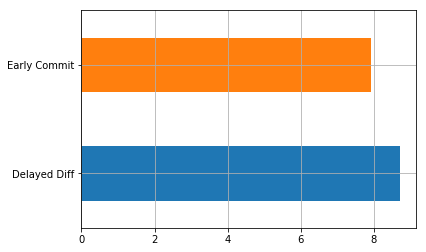

In [575]:
value = pd.Series([-res_SP.fun, -res_LP.fun],
                   index=['Delayed Diff','Early Commit'])
_ = value.plot.barh(grid=True)

In [576]:
d = value['Delayed Diff'] - value['Early Commit']
print('Difference of Expected Values: ${:,.2f}M - ${:,.2f}M = ${:,.2f}M'.\
      format(*value, d))
print('Delayed Commitment Improvement {:.2%}'.format(d/value['Early Commit']))

Difference of Expected Values: $8.72M - $7.93M = $0.79M
Delayed Commitment Improvement 10.00%
